In [43]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [44]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [45]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [46]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [47]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [48]:
# def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

#     history = model.fit(
#       train_generator,
#       validation_data=validation_generator,
#       epochs=epochs,
#       batch_size=batchSize,
#       callbacks=[annealer, checkpoint],
#       steps_per_epoch=len(train_generator),
#       validation_steps=len(validation_generator)
#     )
    
#     return history

# # def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

# #     history = model.fit(
# #       train_generator,
# #       validation_data=validation_generator,
# #       epochs=epochs,
# #       batch_size=batchSize,
# #       callbacks=[annealer, checkpoint],
# #       steps_per_epoch=len(train_generator),
# #       validation_steps=len(validation_generator)
# #     )
    
# #     return history

# def modelFit(model, annealer, checkpoint, epochs = 20, batchSize = 256, validation_steps = 32):
#     # Assuming you have train_generator and validation_generator defined
#     history = model.fit(
#         train_generator,
#         epochs=epochs,
#         validation_data=validation_generator,
#         validation_steps=validation_steps,  # Specify the correct value here
#         callbacks=[annealer, checkpoint],
#         steps_per_epoch=len(train_generator),
#     )
#     return history


import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def modelFit(model, annealer, checkpoint, epochs=20, batchSize=256, validation_steps=32):
    # Assuming you have train_generator and validation_generator defined
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator),
    )

    # Calculate precision, recall, and F1 score on validation data
    val_predictions = model.predict(validation_generator)
    val_classes = np.argmax(val_predictions, axis=1)  # Assuming multiclass classification
    true_classes = validation_generator.classes

    val_precision = precision_score(true_classes, val_classes, average='macro')
    val_recall = recall_score(true_classes, val_classes, average='macro')
    val_f1score = f1_score(true_classes, val_classes, average='macro')

    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1 Score: {val_f1score:.4f}")

    return history


In [49]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [50]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.h5")
    print("Model Saved!")

In [51]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [52]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [53]:
mpath = r'../input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_8[0][0]      

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
625/625 [==============================] - 104s 167ms/step - loss: 0.1254 - accuracy: 0.9667 - val_loss: 0.1540 - val_accuracy: 0.9648

Epoch 00002: val_loss improved from 0.22427 to 0.15403, saving model to Brain CancerMobileNet.h5
Epoch 3/10
625/625 [==============================] - 104s 167ms/step - loss: 0.0830 - accuracy: 0.9810 - val_loss: 0.0815 - val_accuracy: 0.9834

Epoch 00003: val_loss improved from 0.15403 to 0.08150, saving model to Brain CancerMobileNet.h5
Epoch 4/10
625/625 [==============================] - 104s 166ms/step - loss: 0.0620 - accuracy: 0.9862 - val_loss: 0.0941 - val_accuracy: 0.9746

Epoch 00004: val_loss did not improve from 0.08150
Epoch 5/10
625/625 [==============================] - 104s 166ms/step - loss: 0.0488 - accuracy: 0.9898 - val_loss: 0.0583 - val_accuracy: 0.9863

Epoch 00005: val_loss improved from 0.08150 to 0.05835, saving model to Brain CancerMobileNet.h5
Epoch 6/10
625/625 [==============================] - 107s 171ms/step 

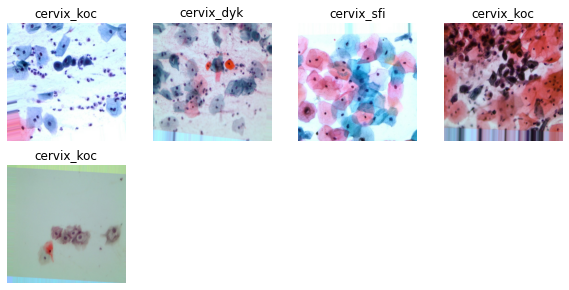

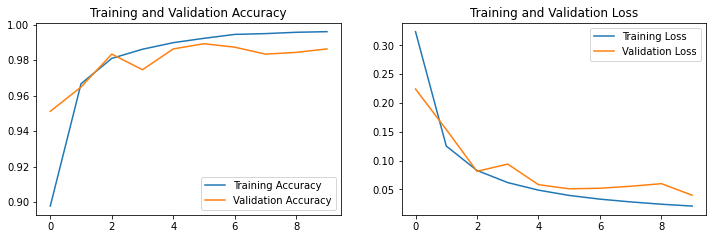

157/157 [==============================] - 26s 165ms/step - loss: 0.0268 - accuracy: 0.9926
Accuracy on the Test Set = 99.26 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

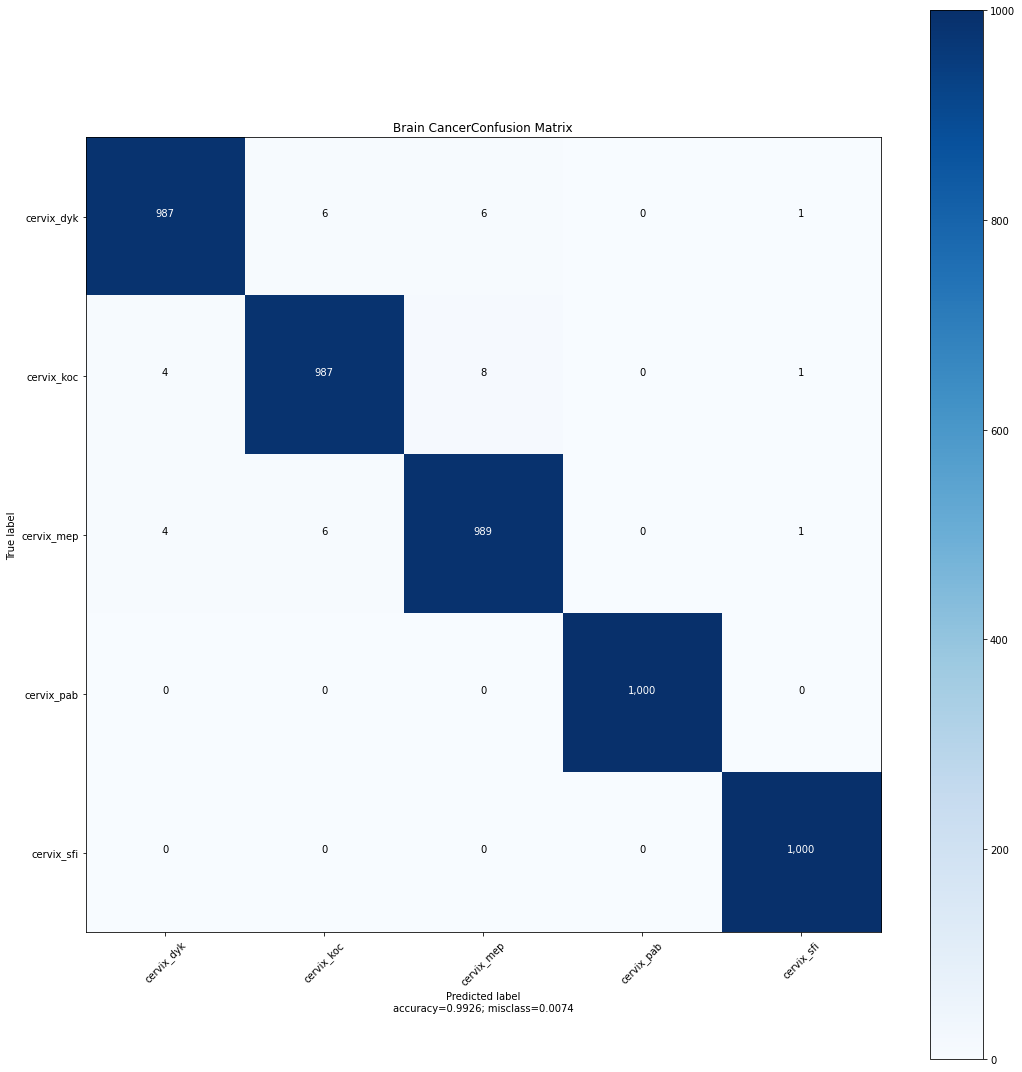

<Figure size 432x288 with 0 Axes>

In [54]:
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_9[0][0]              

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
625/625 [==============================] - 112s 179ms/step - loss: 0.0577 - accuracy: 0.9803 - val_loss: 0.0182 - val_accuracy: 0.9971

Epoch 00002: val_loss improved from 0.03170 to 0.01816, saving model to Brain CancerMobileNet.h5
Epoch 3/10
625/625 [==============================] - 112s 180ms/step - loss: 0.0419 - accuracy: 0.9860 - val_loss: 0.0161 - val_accuracy: 0.9961

Epoch 00003: val_loss improved from 0.01816 to 0.01613, saving model to Brain CancerMobileNet.h5
Epoch 4/10
625/625 [==============================] - 113s 181ms/step - loss: 0.0335 - accuracy: 0.9897 - val_loss: 0.0117 - val_accuracy: 0.9980

Epoch 00004: val_loss improved from 0.01613 to 0.01167, saving model to Brain CancerMobileNet.h5
Epoch 5/10
625/625 [==============================] - 114s 182ms/step - loss: 0.0269 - accuracy: 0.9922 - val_loss: 0.0101 - val_accuracy: 0.9980

Epoch 00005: val_loss improved from 0.01167 to 0.01014, saving model to Brain CancerMobileNet.h5
Epoch 6/10
625/625 [====

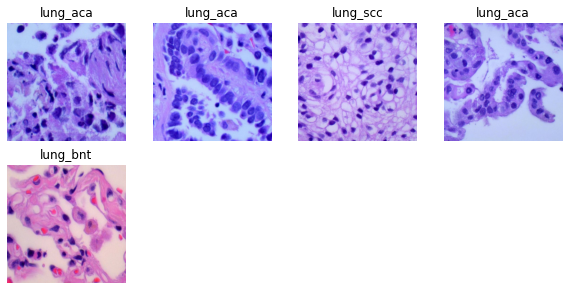

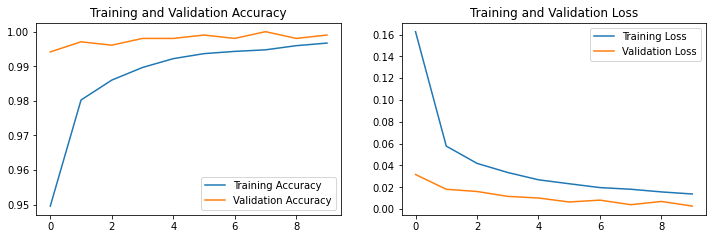

157/157 [==============================] - 28s 175ms/step - loss: 0.0195 - accuracy: 0.9940
Accuracy on the Test Set = 99.40 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 1 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

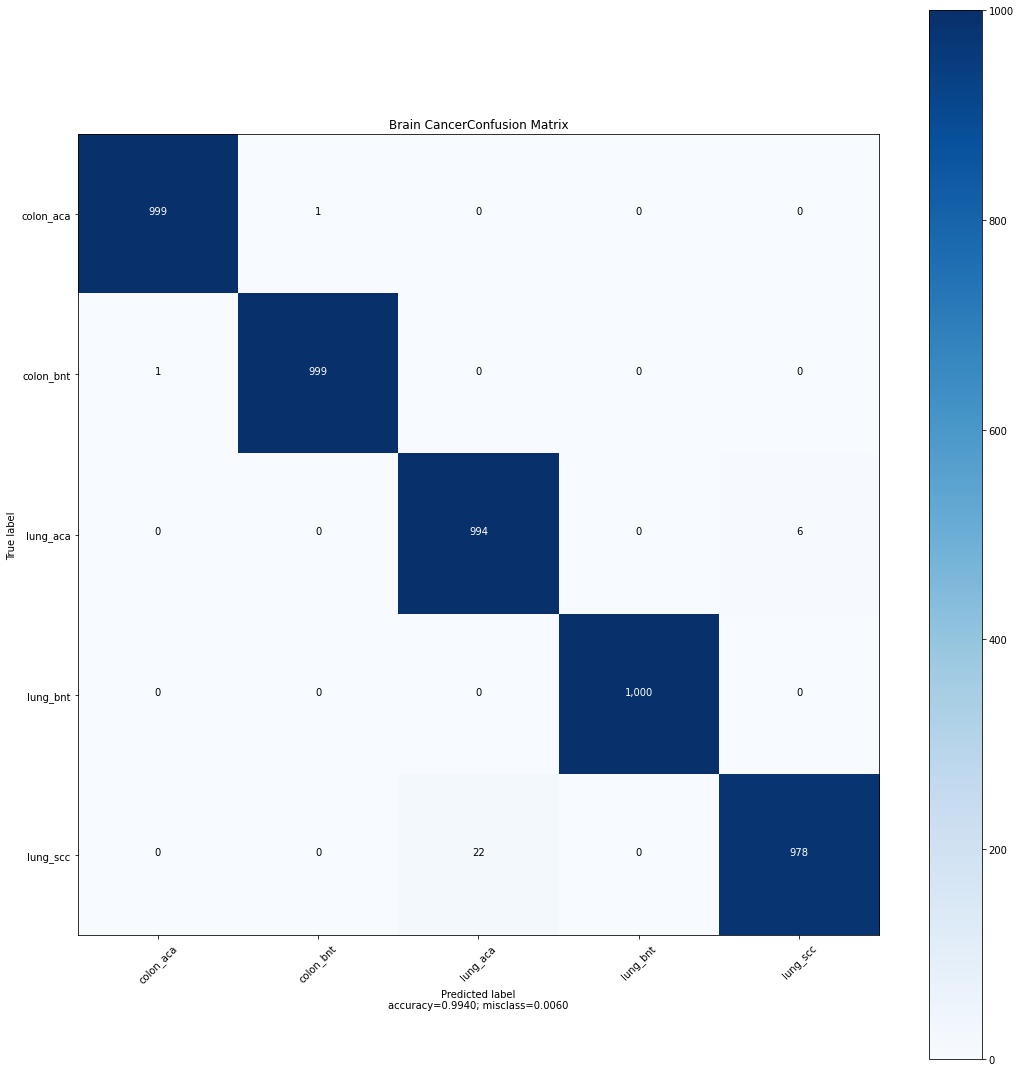

<Figure size 432x288 with 0 Axes>

In [55]:
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 224, 224, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_10[0][0]               
________________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
251/251 [==============================] - 48s 192ms/step - loss: 0.3456 - accuracy: 0.8510 - val_loss: 0.4115 - val_accuracy: 0.8232

Epoch 00002: val_loss improved from 0.55860 to 0.41147, saving model to Brain CancerMobileNet.h5
Epoch 3/10
251/251 [==============================] - 48s 192ms/step - loss: 0.3118 - accuracy: 0.8674 - val_loss: 0.3306 - val_accuracy: 0.8672

Epoch 00003: val_loss improved from 0.41147 to 0.33063, saving model to Brain CancerMobileNet.h5
Epoch 4/10
251/251 [==============================] - 49s 195ms/step - loss: 0.2905 - accuracy: 0.8778 - val_loss: 0.3129 - val_accuracy: 0.8740

Epoch 00004: val_loss improved from 0.33063 to 0.31288, saving model to Brain CancerMobileNet.h5
Epoch 5/10
251/251 [==============================] - 48s 191ms/step - loss: 0.2760 - accuracy: 0.8862 - val_loss: 0.3537 - val_accuracy: 0.8389

Epoch 00005: val_loss did not improve from 0.31288
Epoch 6/10
251/251 [==============================] - 49s 194ms/step - los

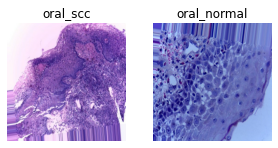

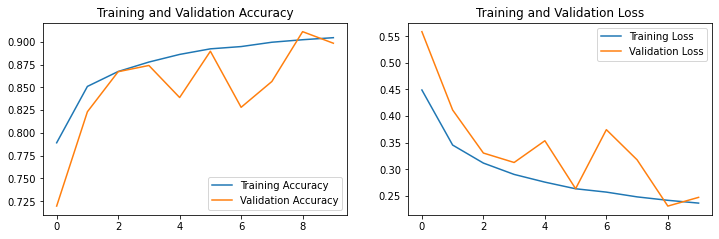

63/63 [==============================] - 11s 169ms/step - loss: 0.3040 - accuracy: 0.8750
Accuracy on the Test Set = 87.50 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

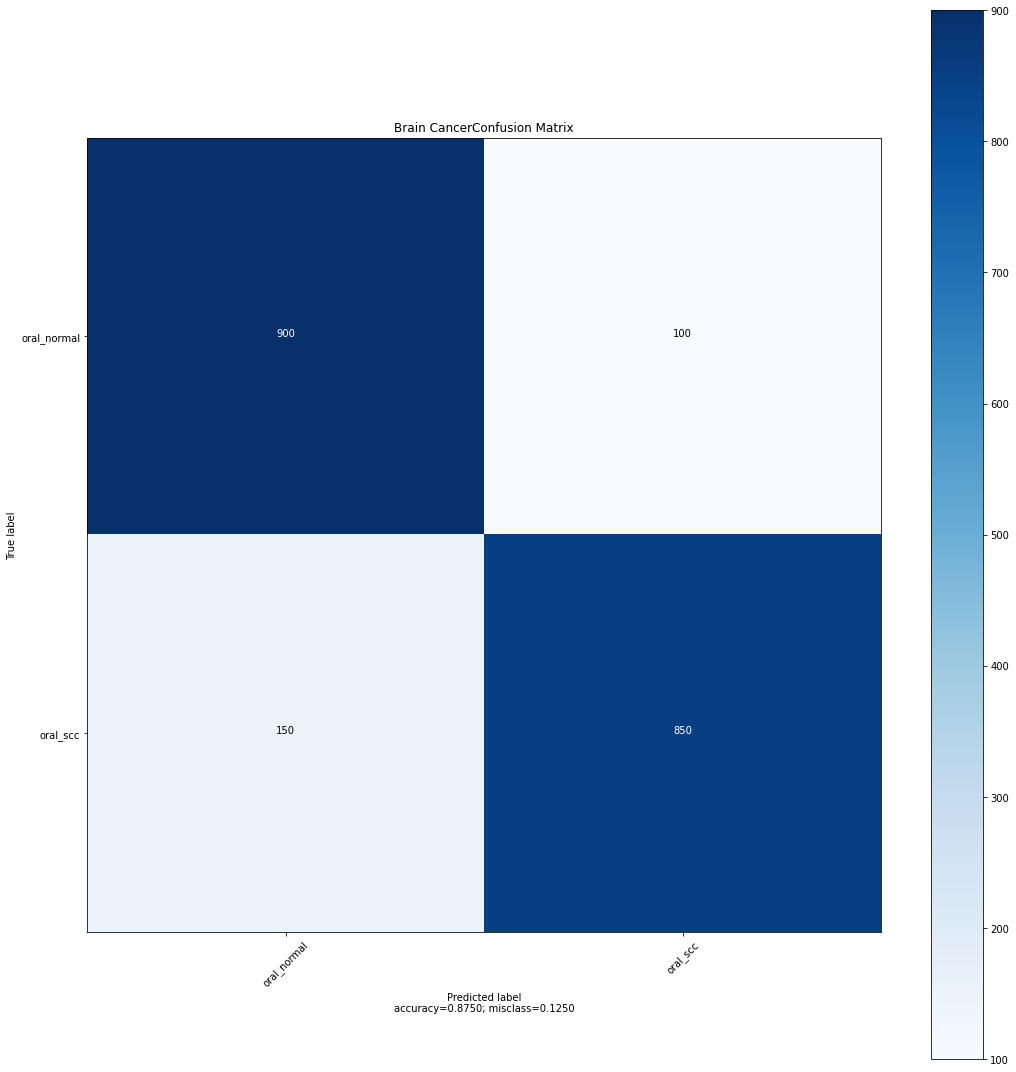

<Figure size 432x288 with 0 Axes>

In [56]:
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 224, 224, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_11[0][0]               
_________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
500/500 [==============================] - 85s 170ms/step - loss: 0.0528 - accuracy: 0.9891 - val_loss: 0.0482 - val_accuracy: 0.9902

Epoch 00002: val_loss improved from 0.09713 to 0.04816, saving model to Brain CancerMobileNet.h5
Epoch 3/10
500/500 [==============================] - 84s 169ms/step - loss: 0.0336 - accuracy: 0.9927 - val_loss: 0.0237 - val_accuracy: 0.9941

Epoch 00003: val_loss improved from 0.04816 to 0.02367, saving model to Brain CancerMobileNet.h5
Epoch 4/10
500/500 [==============================] - 84s 168ms/step - loss: 0.0248 - accuracy: 0.9949 - val_loss: 0.0324 - val_accuracy: 0.9893

Epoch 00004: val_loss did not improve from 0.02367
Epoch 5/10
500/500 [==============================] - 85s 170ms/step - loss: 0.0194 - accuracy: 0.9961 - val_loss: 0.0161 - val_accuracy: 0.9971

Epoch 00005: val_loss improved from 0.02367 to 0.01607, saving model to Brain CancerMobileNet.h5
Epoch 6/10
500/500 [==============================] - 83s 167ms/step - los

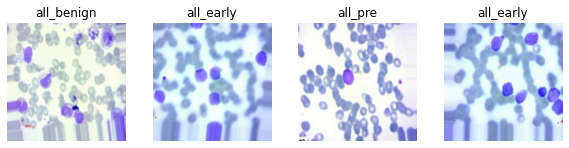

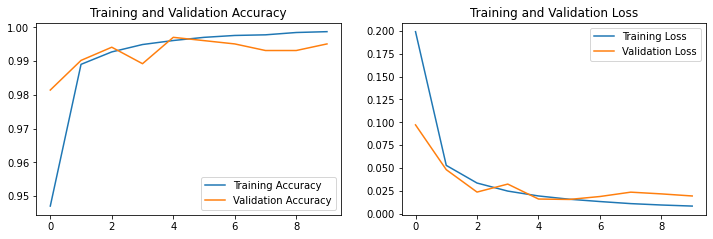

125/125 [==============================] - 20s 158ms/step - loss: 0.0103 - accuracy: 0.9973
Accuracy on the Test Set = 99.73 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 432x288 with 0 Axes>

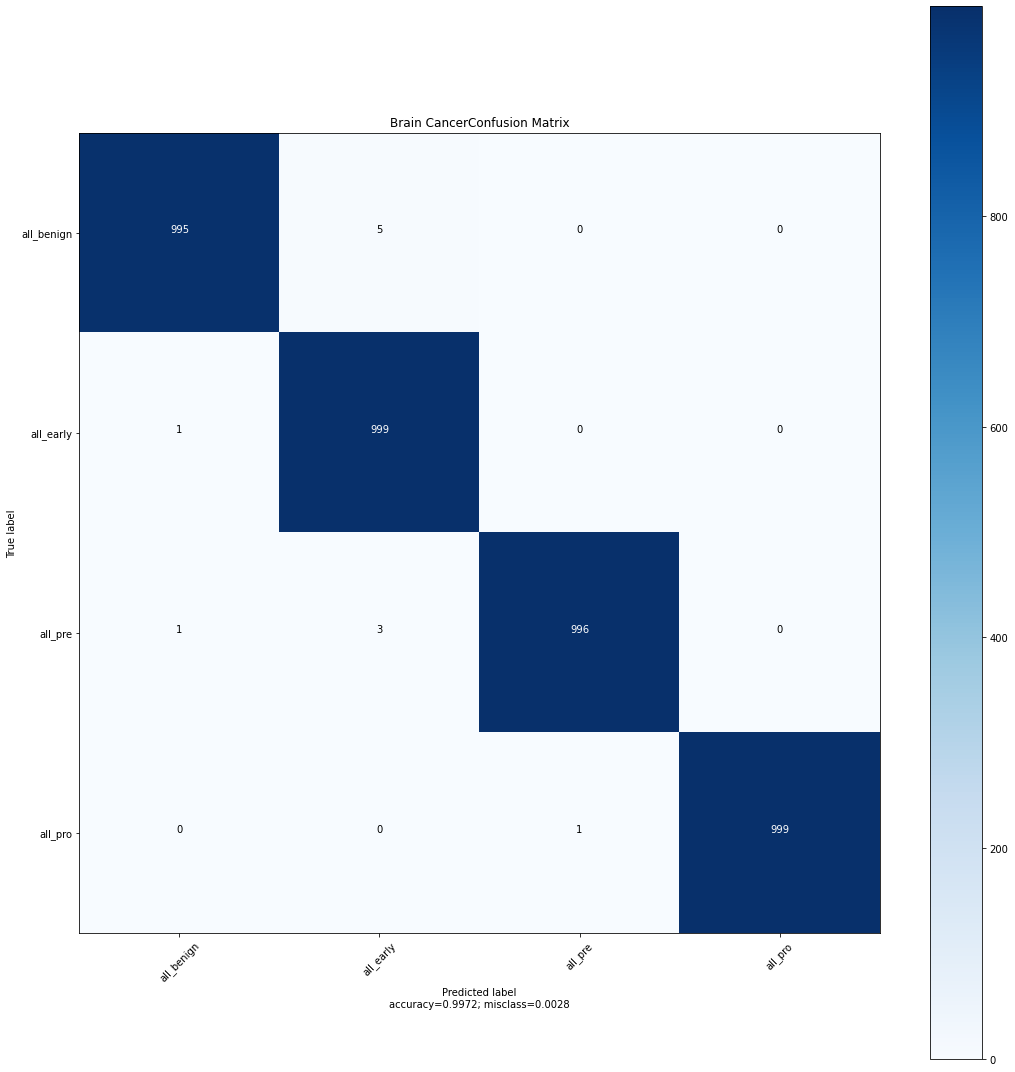

<Figure size 432x288 with 0 Axes>

In [57]:
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_12 (Rescaling)        (None, 224, 224, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_12[0][0]               
__________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
250/250 [==============================] - 43s 173ms/step - loss: 0.0606 - accuracy: 0.9944 - val_loss: 0.2122 - val_accuracy: 0.8994

Epoch 00002: val_loss did not improve from 0.20756
Epoch 3/10
250/250 [==============================] - 43s 173ms/step - loss: 0.0354 - accuracy: 0.9981 - val_loss: 0.2219 - val_accuracy: 0.9004

Epoch 00003: val_loss did not improve from 0.20756
Epoch 4/10
250/250 [==============================] - 44s 174ms/step - loss: 0.0241 - accuracy: 0.9986 - val_loss: 0.1506 - val_accuracy: 0.9268

Epoch 00004: val_loss improved from 0.20756 to 0.15062, saving model to Kidney Cancer MobileNet.h5
Epoch 5/10
250/250 [==============================] - 44s 174ms/step - loss: 0.0178 - accuracy: 0.9990 - val_loss: 0.1988 - val_accuracy: 0.9062

Epoch 00005: val_loss did not improve from 0.15062
Epoch 6/10
250/250 [==============================] - 44s 176ms/step - loss: 0.0140 - accuracy: 0.9991 - val_loss: 0.1993 - val_accuracy: 0.9082

Epoch 00006: val_l

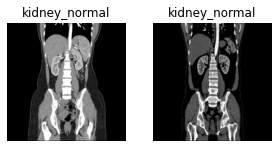

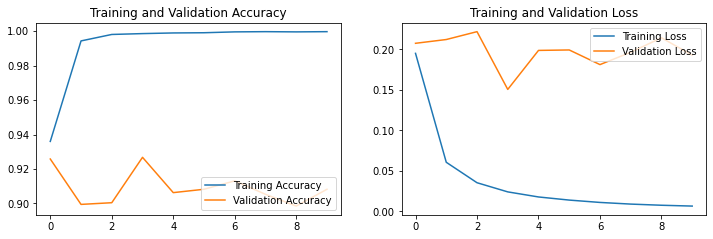

63/63 [==============================] - 9s 149ms/step - loss: 0.1020 - accuracy: 0.9530
Accuracy on the Test Set = 95.30 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

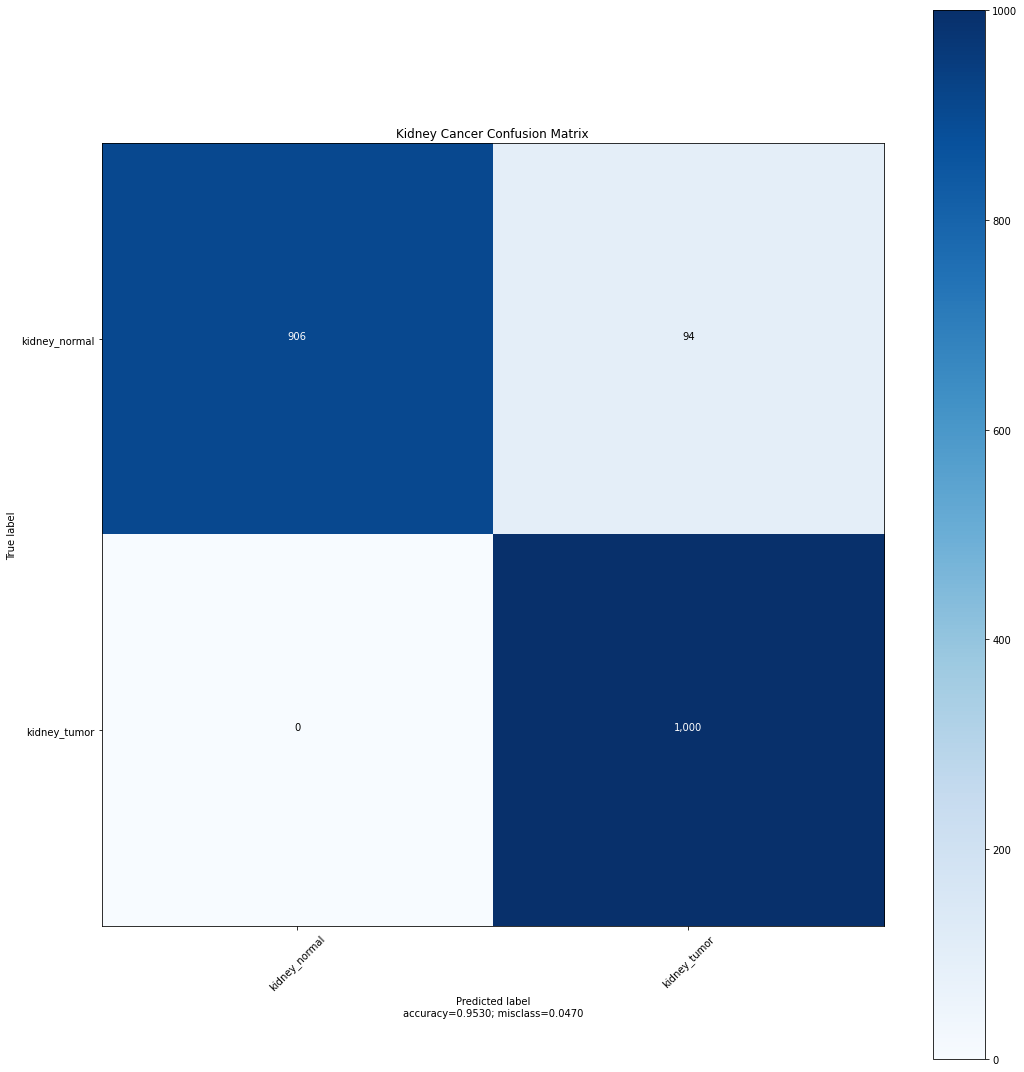

<Figure size 432x288 with 0 Axes>

In [58]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_13 (Rescaling)        (None, 224, 224, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_13[0][0]               
______________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
250/250 [==============================] - 76s 302ms/step - loss: 0.0376 - accuracy: 0.9891 - val_loss: 0.0386 - val_accuracy: 0.9863

Epoch 00002: val_loss improved from 0.04884 to 0.03859, saving model to Breast Cancer MobileNet.h5
Epoch 3/10
250/250 [==============================] - 75s 302ms/step - loss: 0.0281 - accuracy: 0.9914 - val_loss: 0.0422 - val_accuracy: 0.9844

Epoch 00003: val_loss did not improve from 0.03859
Epoch 4/10
250/250 [==============================] - 76s 304ms/step - loss: 0.0233 - accuracy: 0.9934 - val_loss: 0.0487 - val_accuracy: 0.9844

Epoch 00004: val_loss did not improve from 0.03859
Epoch 5/10
250/250 [==============================] - 76s 303ms/step - loss: 0.0194 - accuracy: 0.9944 - val_loss: 0.0267 - val_accuracy: 0.9922

Epoch 00005: val_loss improved from 0.03859 to 0.02672, saving model to Breast Cancer MobileNet.h5
Epoch 6/10
250/250 [==============================] - 77s 307ms/step - loss: 0.0169 - accuracy: 0.9955 - val_loss: 0

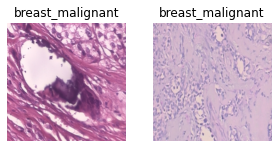

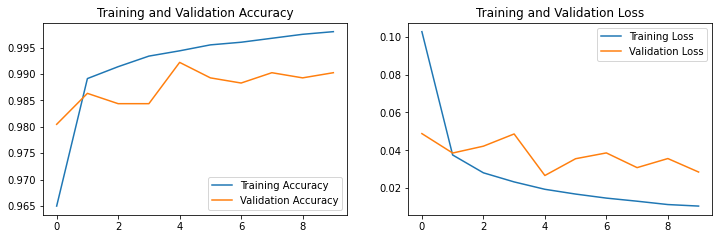

63/63 [==============================] - 18s 293ms/step - loss: 0.0442 - accuracy: 0.9845
Accuracy on the Test Set = 98.45 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

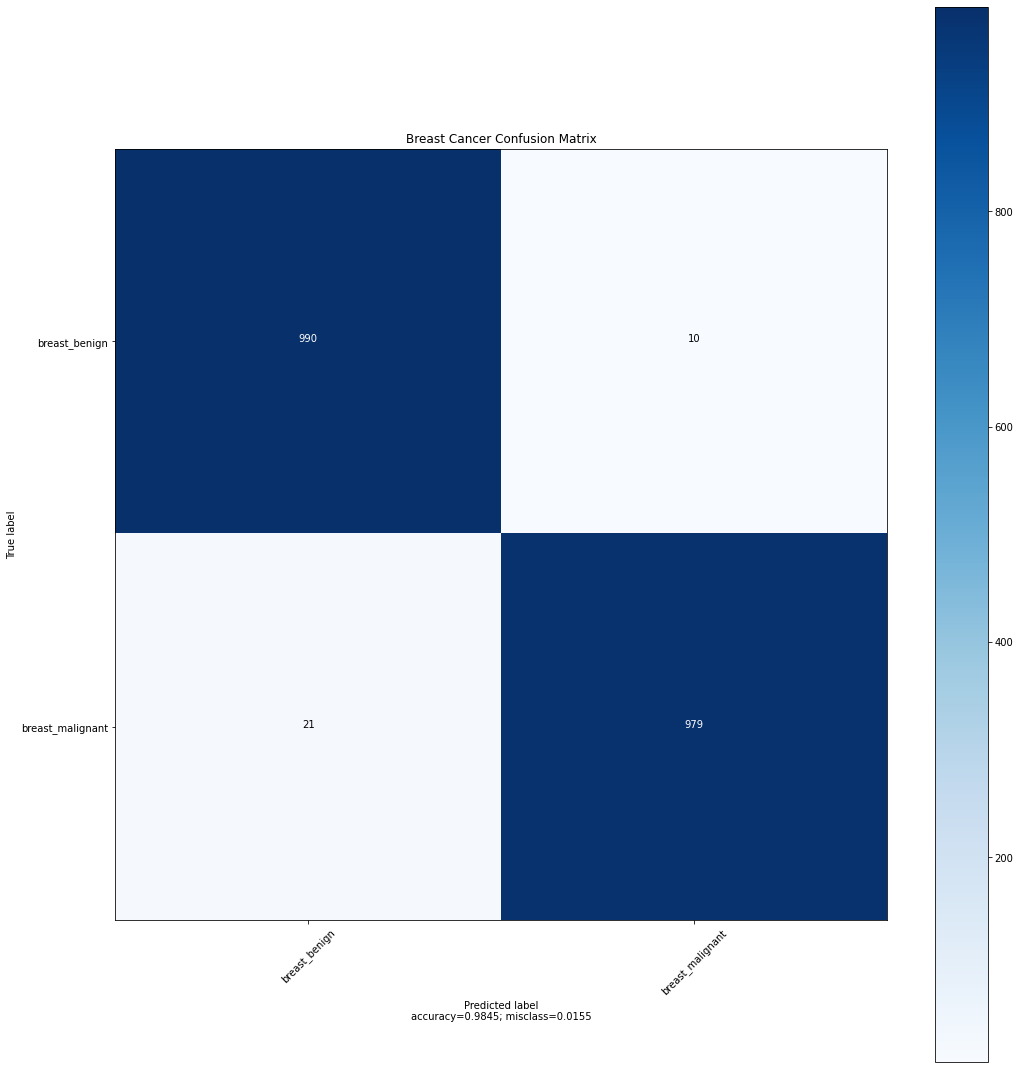

<Figure size 432x288 with 0 Axes>

In [59]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_14 (Rescaling)        (None, 224, 224, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_14[0][0]               
____________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
375/375 [==============================] - 81s 217ms/step - loss: 0.5590 - accuracy: 0.7728 - val_loss: 0.5417 - val_accuracy: 0.7910

Epoch 00002: val_loss did not improve from 0.49175
Epoch 3/10
375/375 [==============================] - 82s 218ms/step - loss: 0.4953 - accuracy: 0.8076 - val_loss: 0.4671 - val_accuracy: 0.8271

Epoch 00003: val_loss improved from 0.49175 to 0.46714, saving model to Lymphoma MobileNet.h5
Epoch 4/10
375/375 [==============================] - 80s 213ms/step - loss: 0.4576 - accuracy: 0.8212 - val_loss: 0.5254 - val_accuracy: 0.7803

Epoch 00004: val_loss did not improve from 0.46714
Epoch 5/10
375/375 [==============================] - 81s 216ms/step - loss: 0.4337 - accuracy: 0.8293 - val_loss: 0.3321 - val_accuracy: 0.8828

Epoch 00005: val_loss improved from 0.46714 to 0.33210, saving model to Lymphoma MobileNet.h5
Epoch 6/10
375/375 [==============================] - 81s 215ms/step - loss: 0.4127 - accuracy: 0.8408 - val_loss: 0.3936 - va

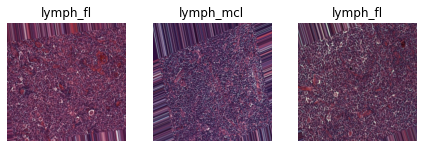

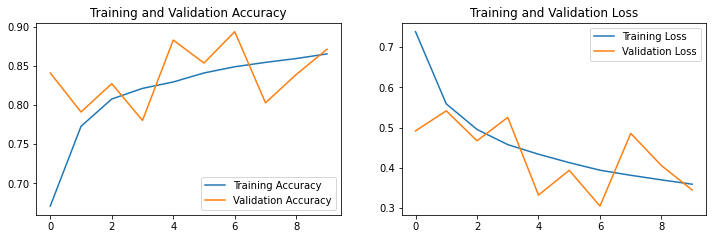

94/94 [==============================] - 19s 200ms/step - loss: 0.3785 - accuracy: 0.8513
Accuracy on the Test Set = 85.13 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

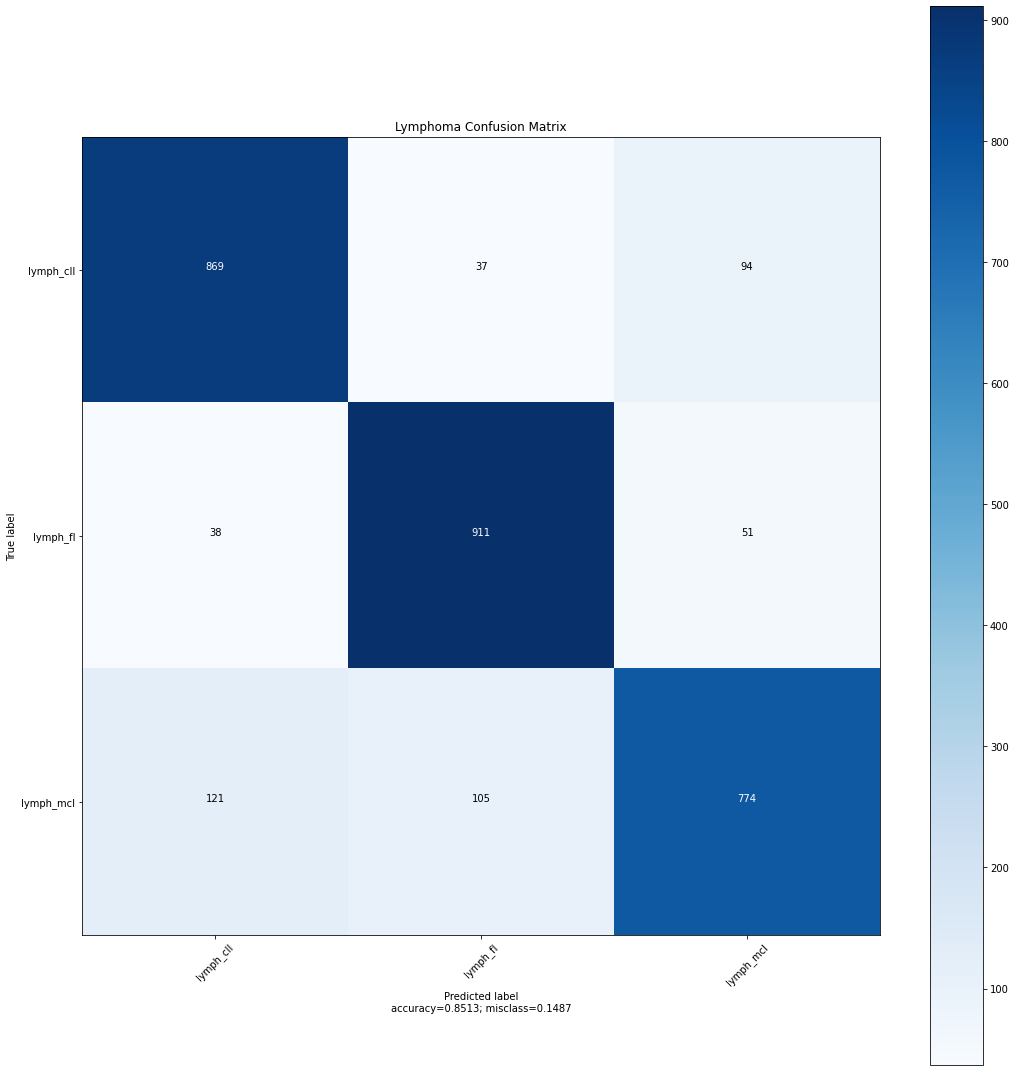

<Figure size 432x288 with 0 Axes>

In [60]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_15 (Rescaling)        (None, 224, 224, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_15[0][0]               
____________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
375/375 [==============================] - 62s 166ms/step - loss: 0.1762 - accuracy: 0.9417 - val_loss: 0.1367 - val_accuracy: 0.9385

Epoch 00002: val_loss improved from 0.15631 to 0.13669, saving model to Brain Cancer MobileNet.h5
Epoch 3/10
375/375 [==============================] - 62s 165ms/step - loss: 0.1419 - accuracy: 0.9537 - val_loss: 0.1147 - val_accuracy: 0.9492

Epoch 00003: val_loss improved from 0.13669 to 0.11473, saving model to Brain Cancer MobileNet.h5
Epoch 4/10
375/375 [==============================] - 63s 167ms/step - loss: 0.1216 - accuracy: 0.9611 - val_loss: 0.0816 - val_accuracy: 0.9619

Epoch 00004: val_loss improved from 0.11473 to 0.08158, saving model to Brain Cancer MobileNet.h5
Epoch 5/10
375/375 [==============================] - 63s 167ms/step - loss: 0.1086 - accuracy: 0.9659 - val_loss: 0.0874 - val_accuracy: 0.9609

Epoch 00005: val_loss did not improve from 0.08158
Epoch 6/10
375/375 [==============================] - 62s 165ms/step - 

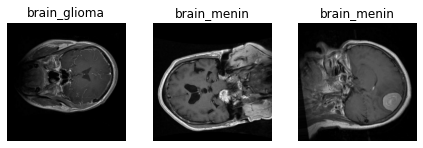

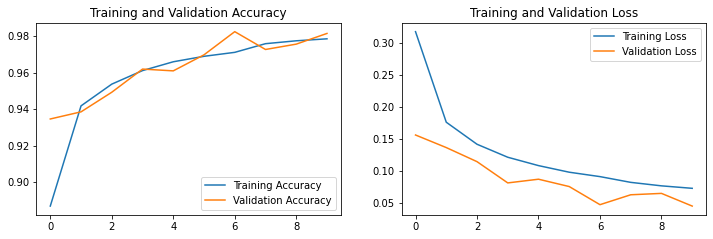

94/94 [==============================] - 15s 155ms/step - loss: 0.0844 - accuracy: 0.9687
Accuracy on the Test Set = 96.87 %


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

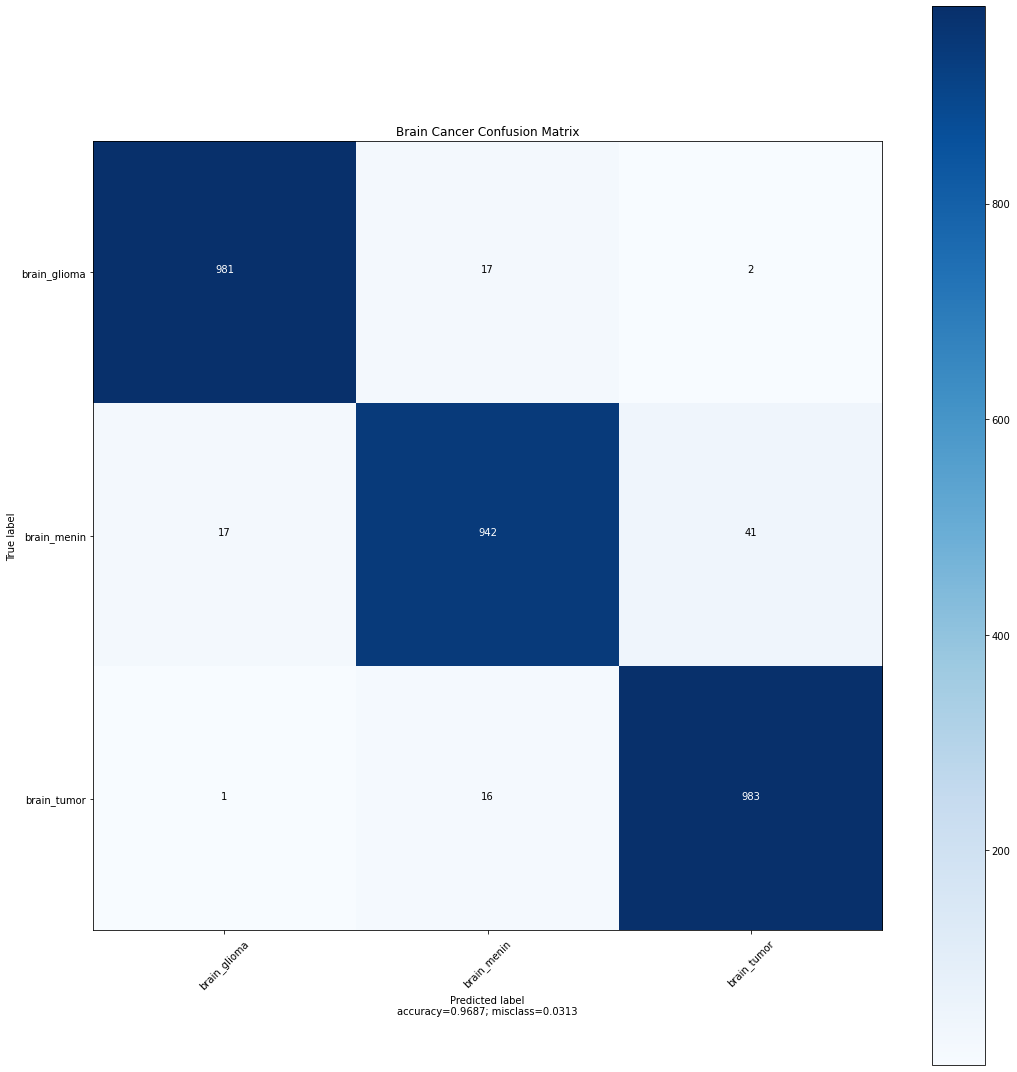

<Figure size 432x288 with 0 Axes>

In [61]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)